# Loading

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Ref_SSC data.csv to Ref_SSC data.csv


# Importing and Loading

In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import math
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from matplotlib import cm

In [ ]:
df = pd.read_csv("Ref_SSC data.csv") 
df = df.drop(columns=["Year","Source","FID","Longitude","Latitude","SSCMGL","SWIR"])

# Pre-Processing

In [ ]:
df_new = [np.log(df['B']),np.log(df['G']),np.log(df['R']),np.log(df['NIR']),np.log(df['SSCGL'])]
df_new = pd.concat((df_new),axis=1)
df_new = df_new.rename({'B':'log(B)','G':'log(G)','R':'log(R)','NIR':'log(NIR)','SSCGL':'log(SSCGL)'},axis=1)
df     = pd.concat((df,df_new),axis=1)

In [ ]:
Xdf = df.drop(columns=["SSCGL","log(SSCGL)"])
Ydf = df[["SSCGL",'log(SSCGL)']]

In [ ]:
colnames=list(Xdf.columns)
combinations=itertools.permutations(colnames,2)
new_combination=list(combinations)
for i in range(len(new_combination)):
    df[str(new_combination[i][0])+'/'+str(new_combination[i][1])]=df[new_combination[i][0]]/df[new_combination[i][1]]
df

,SSCGL,B,G,R,NIR,log(B),log(G),log(R),log(NIR),log(SSCGL),B/G,B/R,B/NIR,B/log(B),B/log(G),B/log(R),B/log(NIR),G/B,G/R,G/NIR,G/log(B),G/log(G),G/log(R),G/log(NIR),R/B,R/G,R/NIR,R/log(B),R/log(G),R/log(R),R/log(NIR),NIR/B,NIR/G,NIR/R,NIR/log(B),NIR/log(G),NIR/log(R),NIR/log(NIR),log(B)/B,log(B)/G,log(B)/R,log(B)/NIR,log(B)/log(G),log(B)/log(R),log(B)/log(NIR),log(G)/B,log(G)/G,log(G)/R,log(G)/NIR,log(G)/log(B),log(G)/log(R),log(G)/log(NIR),log(R)/B,log(R)/G,log(R)/R,log(R)/NIR,log(R)/log(B),log(R)/log(G),log(R)/log(NIR),log(NIR)/B,log(NIR)/G,log(NIR)/R,log(NIR)/NIR,log(NIR)/log(B),log(NIR)/log(G),log(NIR)/log(R)
0,0.075,0.1141,0.1405,0.1432,0.0889,-2.170680,-1.962548,-1.943513,-2.420243,-2.590267,0.812100,0.796788,1.283465,-0.052564,-0.058139,-0.058708,-0.047144,1.231376,0.981145,1.580427,-0.064726,-0.071591,-0.072292,-0.058052,1.255039,1.019217,1.610799,-0.065970,-0.072966,-0.073681,-0.059168,0.779141,0.632740,0.620810,-0.040955,-0.045298,-0.045742,-0.036732,-19.024365,-15.449680,-15.158380,-24.417098,1.106052,1.116885,0.896885,-17.200244,-13.968312,-13.704943,-22.075903,0.904117,1.009794,0.810889,-17.033418,-13.832833,-13.572018,-21.861789,0.895348,0.990301,0.803024,-21.211596,-17.225930,-16.901139,-27.224332,1.114970,1.233215,1.245293
1,0.074,0.1173,0.1424,0.1460,0.0919,-2.143021,-1.949115,-1.924149,-2.387054,-2.603690,0.823736,0.803425,1.276387,-0.054736,-0.060181,-0.060962,-0.049140,1.213981,0.975342,1.549510,-0.066448,-0.073059,-0.074007,-0.059655,1.244672,1.025281,1.588683,-0.068128,-0.074906,-0.075878,-0.061163,0.783461,0.645365,0.629452,-0.042883,-0.047150,-0.047761,-0.038499,-18.269570,-15.049301,-14.678223,-23.319048,1.099484,1.113750,0.897768,-16.616499,-13.687607,-13.350105,-21.209089,0.909518,1.012975,0.816536,-16.403654,-13.512280,-13.179100,-20.937417,0.897868,0.987191,0.806077,-20.349994,-16.763021,-16.349687,-25.974475,1.113874,1.224686,1.240577
2,0.046,0.1243,0.1512,0.1541,0.0930,-2.085057,-1.889152,-1.870154,-2.375156,-3.079114,0.822090,0.806619,1.336559,-0.059615,-0.065797,-0.066465,-0.052333,1.216412,0.981181,1.625806,-0.072516,-0.080036,-0.080849,-0.063659,1.239743,1.019180,1.656989,-0.073907,-0.081571,-0.082400,-0.064880,0.748190,0.615079,0.603504,-0.044603,-0.049228,-0.049729,-0.039155,-16.774395,-13.790061,-13.530547,-22.419971,1.103700,1.114912,0.877861,-15.198325,-12.494390,-12.259259,-20.313460,0.906043,1.010159,0.795380,-15.045483,-12.368740,-12.135974,-20.109178,0.896931,0.989943,0.787381,-19.108253,-15.708702,-15.413081,-25.539310,1.139132,1.257260,1.270033
3,0.031,0.1124,0.1363,0.1378,0.0976,-2.185691,-1.992897,-1.981952,-2.326878,-3.473768,0.824652,0.815675,1.151639,-0.051425,-0.056400,-0.056712,-0.048305,1.212633,0.989115,1.396516,-0.062360,-0.068393,-0.068771,-0.058576,1.225979,1.011005,1.411885,-0.063046,-0.069146,-0.069527,-0.059221,0.868327,0.716067,0.708273,-0.044654,-0.048974,-0.049244,-0.041945,-19.445653,-16.035887,-15.861330,-22.394378,1.096741,1.102797,0.939324,-17.730400,-14.621401,-14.462242,-20.419026,0.911792,1.005522,0.856468,-17.633024,-14.541100,-14.382815,-20.306884,0.906785,0.994508,0.851765,-20.701760,-17.071737,-16.885906,-23.840961,1.064596,1.167586,1.174033
4,0.066,0.1211,0.1477,0.1518,0.0922,-2.111139,-1.912572,-1.885191,-2.383795,-2.718101,0.819905,0.797760,1.313449,-0.057362,-0.063318,-0.064238,-0.050801,1.219653,0.972991,1.601952,-0.069962,-0.077226,-0.078347,-0.061960,1.253509,1.027759,1.646421,-0.071904,-0.079370,-0.080522,-0.063680,0.761354,0.624238,0.607378,-0.043673,-0.048207,-0.048908,-0.038678,-17.433019,-14.293423,-13.907369,-22.897382,1.103822,1.119854,0.885621,-15.793329,-12.949032,-12.599289,-20.743732,0.905943,1.014524,0.802322,-15.567229,-12.763652,-12.418916,-20.446762,0.892974,0.985684,0.790836,-19.684518,-16.139439,-15.703525,-25.854611,1.129151,1.246382,1.264484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
y_col       = 'log(SSCGL)'
A           = df.corr() 
Good_corr   = list(A[abs(A[y_col])>=0.6].index)
Good_corr

['SSCGL', 'B', 'log(SSCGL)', 'B/log(B)', 'B/log(R)']

In [ ]:
Y = df[y_col]
# X = Xdf.to_numpy()
X = df[Good_corr]
X = X.drop(columns=['log(SSCGL)','SSCGL'])
Good_corr = list(X.columns)

In [ ]:
Good_corr

['B', 'B/log(B)', 'B/log(R)']

### Normalization


In [ ]:
df.describe()[['B','G','R','NIR','SSCGL','log(SSCGL)']]

,B,G,R,NIR,SSCGL,log(SSCGL)
count,63.000000,63.000000,63.00000,63.000000,63.000000,63.000000
mean,0.104017,0.121321,0.12333,0.087370,0.188254,-2.097227
std,0.020700,0.035352,0.03559,0.034376,0.185702,0.937943
min,0.040400,0.026500,0.03020,0.012100,0.019000,-3.963316
25%,0.087900,0.102700,0.10565,0.091800,0.069000,-2.674595
50%,0.113800,0.137000,0.13920,0.095000,0.101000,-2.292635
75%,0.119700,0.145300,0.14910,0.101250,0.277500,-1.282950
max,0.125600,0.154300,0.15830,0.162200,0.823000,-0.194799


### Outliers

In [ ]:
clf     = IsolationForest(random_state=0)
OT_mask = clf.fit_predict(X)
X       = X[OT_mask==1]
y       = y[OT_mask==1]

NameError: ignored

In [ ]:
outlier = X[OT_mask==-1]
proper  = X[OT_mask==1]
plt.scatter(outlier[:,0],outlier[:,1],c='r')
plt.scatter(proper[:,0],proper[:,1],c='g')

### Plots

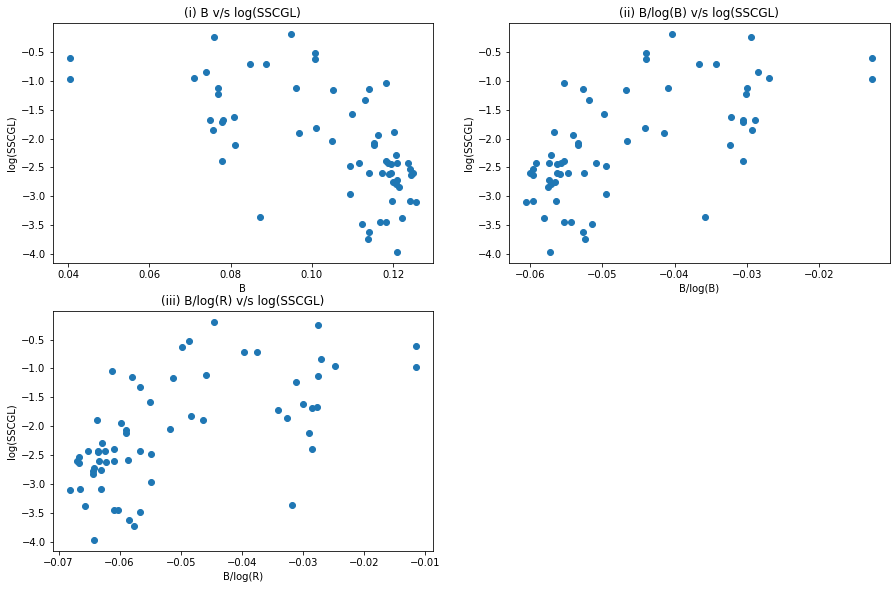

In [ ]:
f       = plt.figure(figsize=(15,15))
z = ['(i)','(ii)','(iii)']
for i,col in enumerate(Good_corr):
    ax=f.add_subplot(len(Good_corr),2,i+1)
    ax.scatter(X[col],Y)
    plt.xlabel(col)
    plt.ylabel(y_col )
    plt.title(z[i]+' '+col+' v/s '+ y_col )

In [ ]:
X.corr()

,B,B/log(B),B/log(R)
B,1.000000,-0.997399,-0.990448
B/log(B),-0.997399,1.000000,0.994736
B/log(R),-0.990448,0.994736,1.000000


Text(0.5, 1.0, 'Boxplot of Values of input vector X')

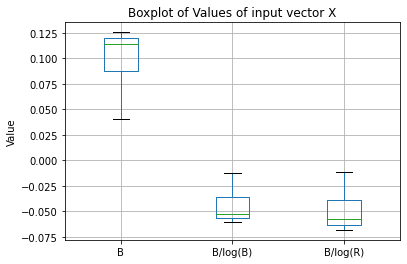

In [ ]:
ax = X.boxplot()
ax.set_ylabel('Value')
ax.set_title('Boxplot of Values of input vector X')

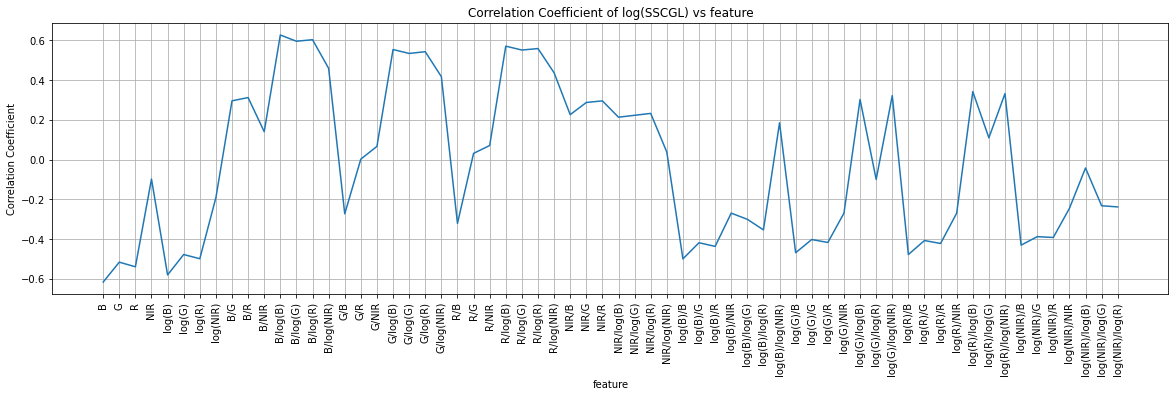

In [ ]:
f = plt.figure(figsize=(20,5))
t = A[y_col].drop(['log(SSCGL)','SSCGL'])
k = list(t.index)
x = t.plot(rot=90,grid=True)
x = plt.xticks(range(0,len(k)), k)
plt.title('Correlation Coefficient of '+y_col+' vs feature')
plt.xlabel('feature')
plt.ylabel('Correlation Coefficient')
plt.show()

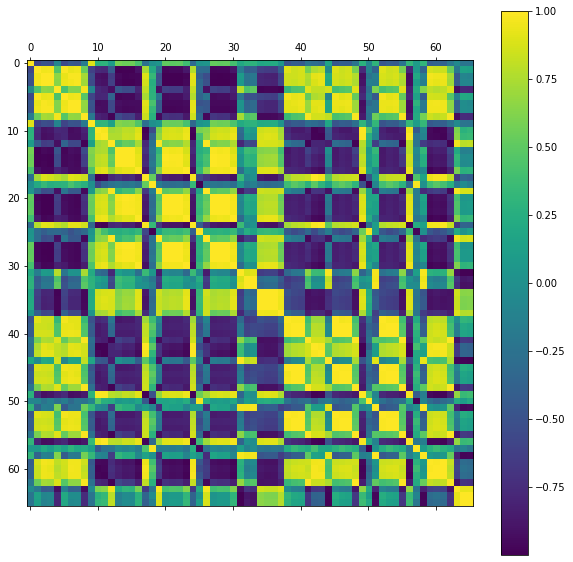

In [ ]:
f = plt.figure(figsize=(10,10))
plt.matshow(A,0)
plt.colorbar()


# Models

## Linear Regression

### Model Train

In [ ]:
DEGREE  = 1
poly    = PolynomialFeatures(DEGREE)
X0      = X.to_numpy()
y       = Y.to_numpy().reshape(-1,1)
X1      = poly.fit_transform(X0)

In [ ]:
y.shape

(63, 1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X1, y, test_size=0.10, random_state=33)

LASSO

In [ ]:
clf = linear_model.Lasso(alpha=0.01,max_iter=100000,fit_intercept=False,normalize=False)
clf.fit(X1,y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

RIDGE


In [ ]:
clf = linear_model.Ridge(alpha=0.001,fit_intercept=False,normalize=False)
clf.fit(X_train,Y_train)

Ridge(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

**LINEAR**

In [ ]:
clf = linear_model.LinearRegression(fit_intercept=False,normalize=True)
clf.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

### Test

In [ ]:
print('a=',clf.coef_.reshape(-1,))

a= [  -2.5572293   130.43617975  413.71859512 -122.45905735]


In [ ]:
clf.score(X_test,Y_test)

0.5590588499116642

In [ ]:
pred = clf.predict(X_test).reshape(-1,1)
np.concatenate((pred ,Y_test.reshape(-1,1)),axis=1)

array([[-1.0827144 , -0.614336  ],
       [-2.57659291, -3.44201938],
       [-2.319797  , -3.72970145],
       [-2.04503707, -2.47693848],
       [-1.70719761, -1.81400508],
       [-2.37144409, -2.07147337],
       [-1.49438914, -0.63299326]])

In [ ]:
clf.coef_ = np.array([-2.6606096487666253 , 2.94894832,  5.26412759, -1.83913191])

Text(0.5, 1.0, '(i)Residua values in trainset')

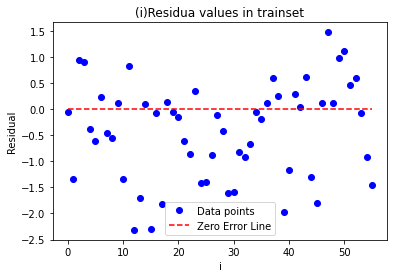

In [ ]:
pred = clf.predict(X_train).reshape(-1,1)
plt.plot(pred-Y_train,'bo')
plt.plot(Y_train-Y_train,'r',ls='--')
plt.xlabel('i')
plt.ylabel('Residual')
plt.legend(['Data points','Zero Error Line'])
plt.title('(i)Residua values in trainset')

Text(0, 0.5, 'Residuals')

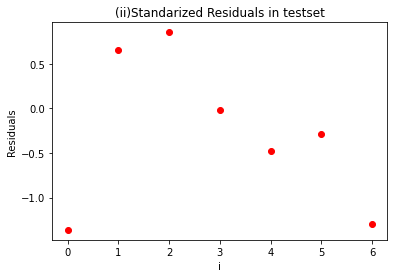

In [ ]:
pred = clf.predict(X_test).reshape(-1,1)
MSres = np.sum((pred-Y_test)**2)/(pred.shape[0]-2)
plt.plot((pred.flatten()-Y_test.flatten())/math.sqrt(MSres),'ro')
plt.title('(ii)Standarized Residuals in testset')
plt.xlabel('i')
plt.ylabel('Residuals')

In [ ]:
from collections import Counter
pred = clf.predict(X_test).reshape(-1,)
MSres = np.sum((pred-Y_test)**2)/(pred.shape[0]-2)
Counter(list((np.abs((pred-Y_test)/math.sqrt(MSres))>2).flatten()))

Counter({False: 49})

Text(0.5, 0, 'B')

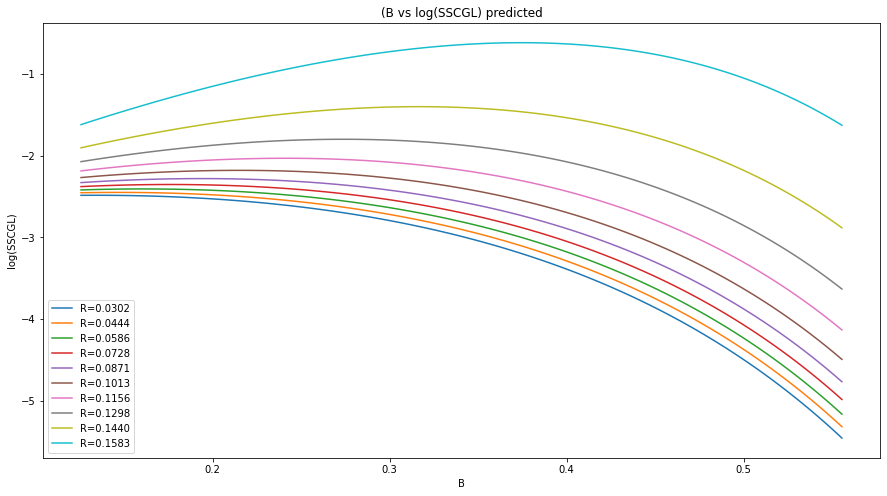

In [ ]:
brks= 10
# Br  = np.linspace(0.0404,0.1256,100)
Br  = np.linspace(0.1256,0.5556,100)
Rr  = np.linspace(0.03020,0.15830,brks)
XT  = np.ones((100,4))
k   = [] 
f   = plt.figure(figsize=(15,8))
for i in range(brks):
    Rtemp = np.ones(100)*Rr[i]
    XT[:,1] = Br
    XT[:,2] = Br/np.log(Br)
    XT[:,3] = Br/np.log(Rtemp*5)
    pred = clf.predict(XT).reshape(-1,1)
    plt.plot(Br,pred)
    k += ['R='+str(Rr[i])[:6]]
# k+= ['True points']
# plt.scatter(df['B'],Y)
plt.legend(k)
plt.title('(B vs '+y_col+' predicted')
plt.ylabel(y_col)
plt.xlabel('B')

Text(0.5, 0, 'R')

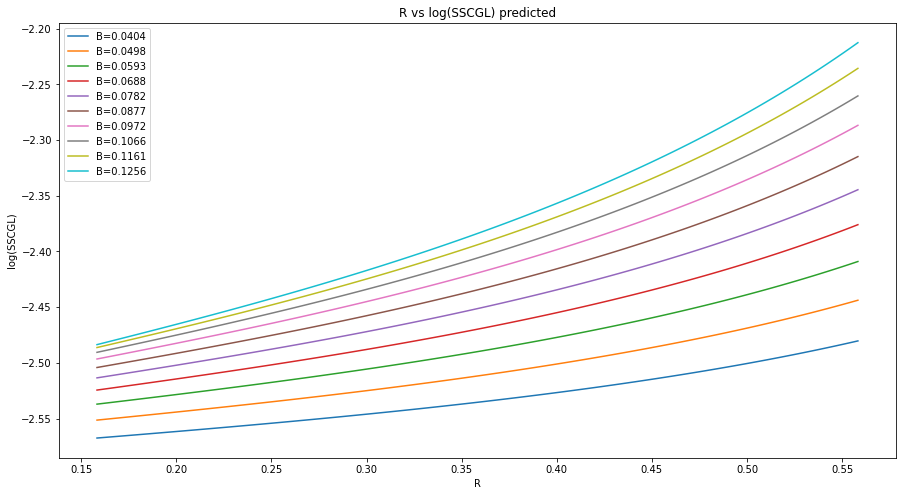

In [ ]:
brks= 10
Br  = np.linspace(0.0404,0.1256,brks)
# Rr  = np.linspace(0.03020,0.15830,100)
Rr  = np.linspace(0.15830,0.55830,100)
XT  = np.ones((100,4))
k   = [] 
f   = plt.figure(figsize=(15,8))
for i in range(brks):
    Btemp = np.ones(100)*Br[i]
    XT[:,1] = Btemp
    XT[:,2] = Btemp/np.log(Btemp)
    XT[:,3] = Btemp/np.log(Rr)
    pred = clf.predict(XT).reshape(-1,1)
    plt.plot(Rr,pred)
    k += ['B='+str(Br[i])[:6]]
# k+= ['True points']
# plt.scatter(df['R'],Y)
plt.legend(k)
plt.title('R vs '+y_col+' predicted')
plt.ylabel(y_col)
plt.xlabel('R')

In [ ]:
Rr 
pred = clf.predict(X_test).reshape(-1,1)

In [ ]:
import matplotlib
matplotlib.colors

<module 'matplotlib.colors' from '/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py'>